# Exercise 2: A Model with Linear and Non-linear Parameters

*This is the companion notebook to Exercise 2 in Hogg, Price-Whelan & Leistedt (2020).*

In [1]:
# Standard library packages
import os
import sys

# Third-party packages
import astropy.table as at
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Included with this repository
from helpers import log_multivariate_gaussian

# Set up a deterministic random number generator:
#  Note: this requires numpy>=1.17
rnd = np.random.Generator(np.random.PCG64(seed=8675309))

For this exercise, we will use a sinusoidal function as our parametric model, with three linear parameters (the amplitudes and a constant offset) and one non-linear parameter (the frequency):
$$
f(x \,;\, \alpha, \beta, \gamma, \omega) = \alpha\, \cos(\omega \, x) + \beta \, \sin(\omega \, x) + \gamma
$$

To start off, let's define true parameter values, which we will use to generate the simulated data,
$(\alpha, \beta, \gamma, \omega)$:

In [2]:
true_pars = (3.21, 2.44, 13.6, 1.27)
K = len(true_pars)

Let's also define a function to evaluate this model, given a list of parameter values:

In [3]:
def model(x, α, β, γ, ω):
    return (α * np.cos(ω * x) + 
            β * np.sin(ω * x) + 
            γ)

We can now generate our simulated data and store it as an astropy `Table` object for easy writing and printing to latex (for including in the companion paper). We round the values to make it more concise when including the data in the companion article. The ranges used below in the random number generators were chosen arbitrarily.

In [4]:
N = 4

t = at.Table()
t['x'] = np.round(np.sort(rnd.uniform(-5, 5, size=N)), 
                  decimals=1)
sigma_y = np.round(np.sort(rnd.uniform(0.1, 0.5, size=N)), 
                   decimals=1)
t['y'] = np.round(rnd.normal(model(t['x'], *true_pars),
                             sigma_y),
                  decimals=1)
t['sigma_y'] = sigma_y

t.write('data2.csv', overwrite=True)
t.write(sys.stdout, format='ascii.latex')

\begin{table}
\begin{tabular}{ccc}
x & y & sigma_y \\
-1.2 & 11.2 & 0.2 \\
1.3 & 16.1 & 0.2 \\
3.1 & 10.2 & 0.3 \\
4.1 & 13.5 & 0.3 \\
\end{tabular}
\end{table}


We again assume that the data are independent so that the covariance tensor of the data, $\mathrm{C}$, is diagonal:

In [5]:
C = np.diag(t['sigma_y'] ** 2)

We can also specify the Gaussian prior parameters (mean `mu` and variance tensor `L`) for the two amplitudes ($\alpha$, $\beta$) and the constant offset ($\gamma$):

In [6]:
mu = np.array([0, 0, 0])

sigmas = np.array([5, 5, 10])
L = np.diag(sigmas ** 2)

We are not able to analytically marginalize over all of the parameters because of the nonlinear parameter in our model ($\omega$). However, we can still marginalize over the subset of linear parameters given a value for $\omega$ - a consequence of this is that the design matrix in this problem is therefore a function of the nonlinear parameter(s) ($\omega$ here):

In [7]:
def design_matrix(x, ω):
    M = np.ones((len(x), 3))
    M[:, 0] = np.cos(ω * x)
    M[:, 1] = np.sin(ω * x)
    return M

At any value of $\omega$ (i.e. conditioned on $\omega$), we can therefore compute the MAP parameter vector $a$, the posterior variance tensor $A$, and the vector and the corresponding prior-optimal vector and tensor $b$, $B$ (following the notation in the companion article, Equations 10–13). This enables us to compute the value of the log-marginal-likelihood, which effectively reduces the dimensionality of the problem to the number of non-linear parameters (here, 1).
<span style="color:red;">TODO: we probably shouldn't say "posterior" here, eh?</span>

In [8]:
def compute_aA_bB(omega, x, y, C, mu, L):
    M = design_matrix(x, omega)
    
    Cinv = np.linalg.inv(C)
    Linv = np.linalg.inv(L)
    
    b = M @ mu
    B = C + M @ L @ M.T

    Ainv = Linv + M.T @ Cinv @ M
    A = np.linalg.inv(Ainv)
    Binv = Cinv - Cinv @ M @ A @ M.T @ Cinv
    a = np.linalg.solve(Ainv, Linv @ mu + M.T @ Cinv @ y)
    
    # By evaluating the Gaussian in b, B, we obtain the value
    #  of the log-marginal-likelihood:
    loglike = log_multivariate_gaussian(y, b, B, Vinv=Binv)

    return {
        'a': a, 'A': A,
        'b': b, 'B': B,
        'ln_marg_likelihood': loglike
    }

<span style="color:red;">TODO: Why do this? What does this enable? We can now use any sampling method for the nonlinear parameter</span>

We are now set up to compute ...

In [9]:
compute_aA_bB(1., t['x'], t['y'], C, mu, L)

{'a': array([ 1.36572211,  2.09398469, 13.35461393]),
 'A': array([[ 0.05075097, -0.00253481,  0.00094876],
        [-0.00253481,  0.01951542,  0.00205758],
        [ 0.00094876,  0.00205758,  0.0140905 ]]),
 'b': array([0., 0., 0., 0.]),
 'B': array([[125.04      ,  79.97140961,  89.9800207 , 113.8593584 ],
        [ 79.97140961, 125.04      ,  94.31994763,  76.44444148],
        [ 89.9800207 ,  94.31994763, 125.09      , 113.50755765],
        [113.8593584 ,  76.44444148, 113.50755765, 125.09      ]]),
 'ln_marg_likelihood': -76.3276462599734}

In [10]:
def ln_marginal_likelihood(*args, **kwargs):
    """
    Helper function that extracts and returns the log-marginal-likelihood value.
    """
    res = compute_aA_bB(*args, **kwargs)
    return res['ln_marg_likelihood']

In [11]:
omega_lim = (1e-2, 1e2)
# omega_grid = np.geomspace(*omega_lim, 16384)
omega_grid = np.linspace(0.5, 100, 16384)
lnlike_grid = np.array([ln_marginal_likelihood(omega, t['x'], t['y'], C, mu, L) 
                         for omega in omega_grid])

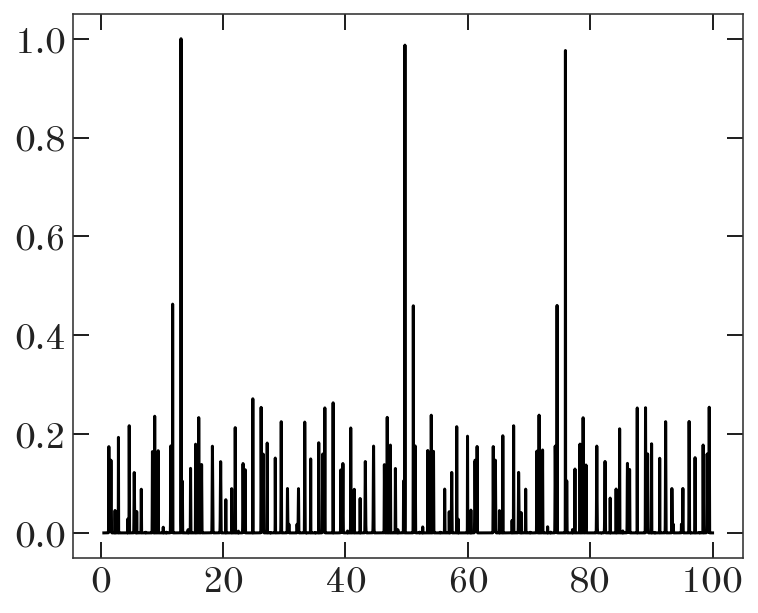

In [12]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(omega_grid, np.exp(lnlike_grid - lnlike_grid.max()),
        marker='')
# ax.set_xscale('log')

In [13]:
n_prior_samples = 2**18
prior_omega_samples = np.exp(rnd.uniform(*np.log(omega_lim), 
                                         size=n_prior_samples))

In [14]:
marg_lnlikes = np.array([ln_marginal_likelihood(omega, t['x'], t['y'], C, mu, L) 
                         for omega in prior_omega_samples])

In [15]:
mask = np.exp(marg_lnlikes - marg_lnlikes.max()) > rnd.uniform(size=n_prior_samples)
mask.sum()

1612

In [16]:
def make_full_parameter_vector(omega, x, y, C, mu, L):
    """Expand"""
    res = compute_aA_bB(omega, x, y, C, mu, L)
    linear_sample = rnd.multivariate_normal(res['a'], res['A'])
    return np.concatenate((linear_sample, [omega]))

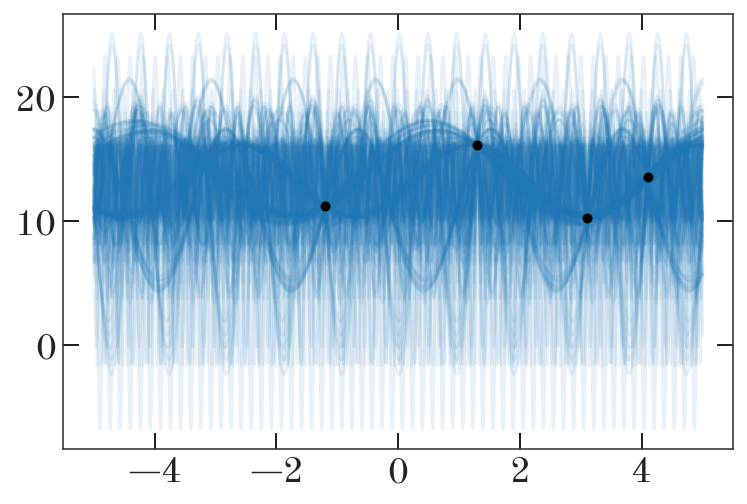

In [17]:
plt.errorbar(t['x'], t['y'], t['sigma_y'], 
             marker='o', ls='none')

grid_x = np.linspace(-5, 5, 2048)
for omega in prior_omega_samples[mask][:128]:
    full_sample = make_full_parameter_vector(omega, t['x'], t['y'], C, mu, L)
    plt.plot(grid_x, model(grid_x, *full_sample),
             marker='', alpha=0.1, color='tab:blue')

In [18]:
samples = []
for omega in prior_omega_samples[mask][:1024]:
    full_sample = make_full_parameter_vector(omega, t['x'], t['y'], C, mu, L)
    samples.append(full_sample)
samples = np.array(samples)

In [19]:
samples[:, -1].min(), samples[:, -1].max()

(1.2667827790794082, 99.47503232590991)

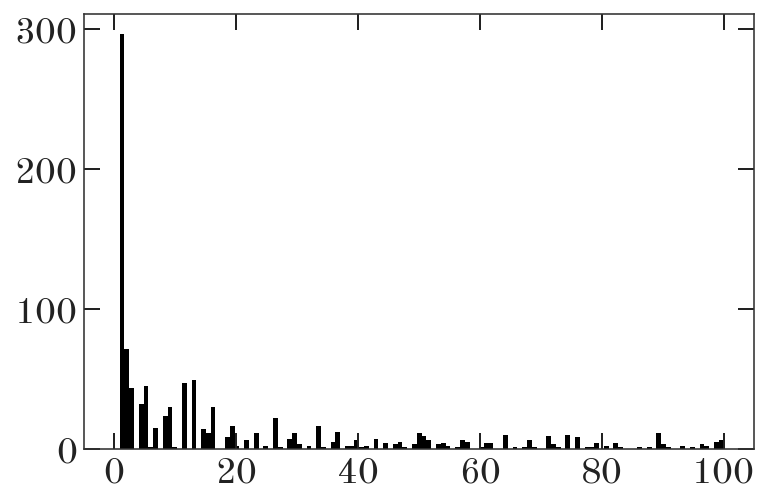

In [20]:
plt.hist(samples[:, -1], bins=np.linspace(0.1, 100, 128));

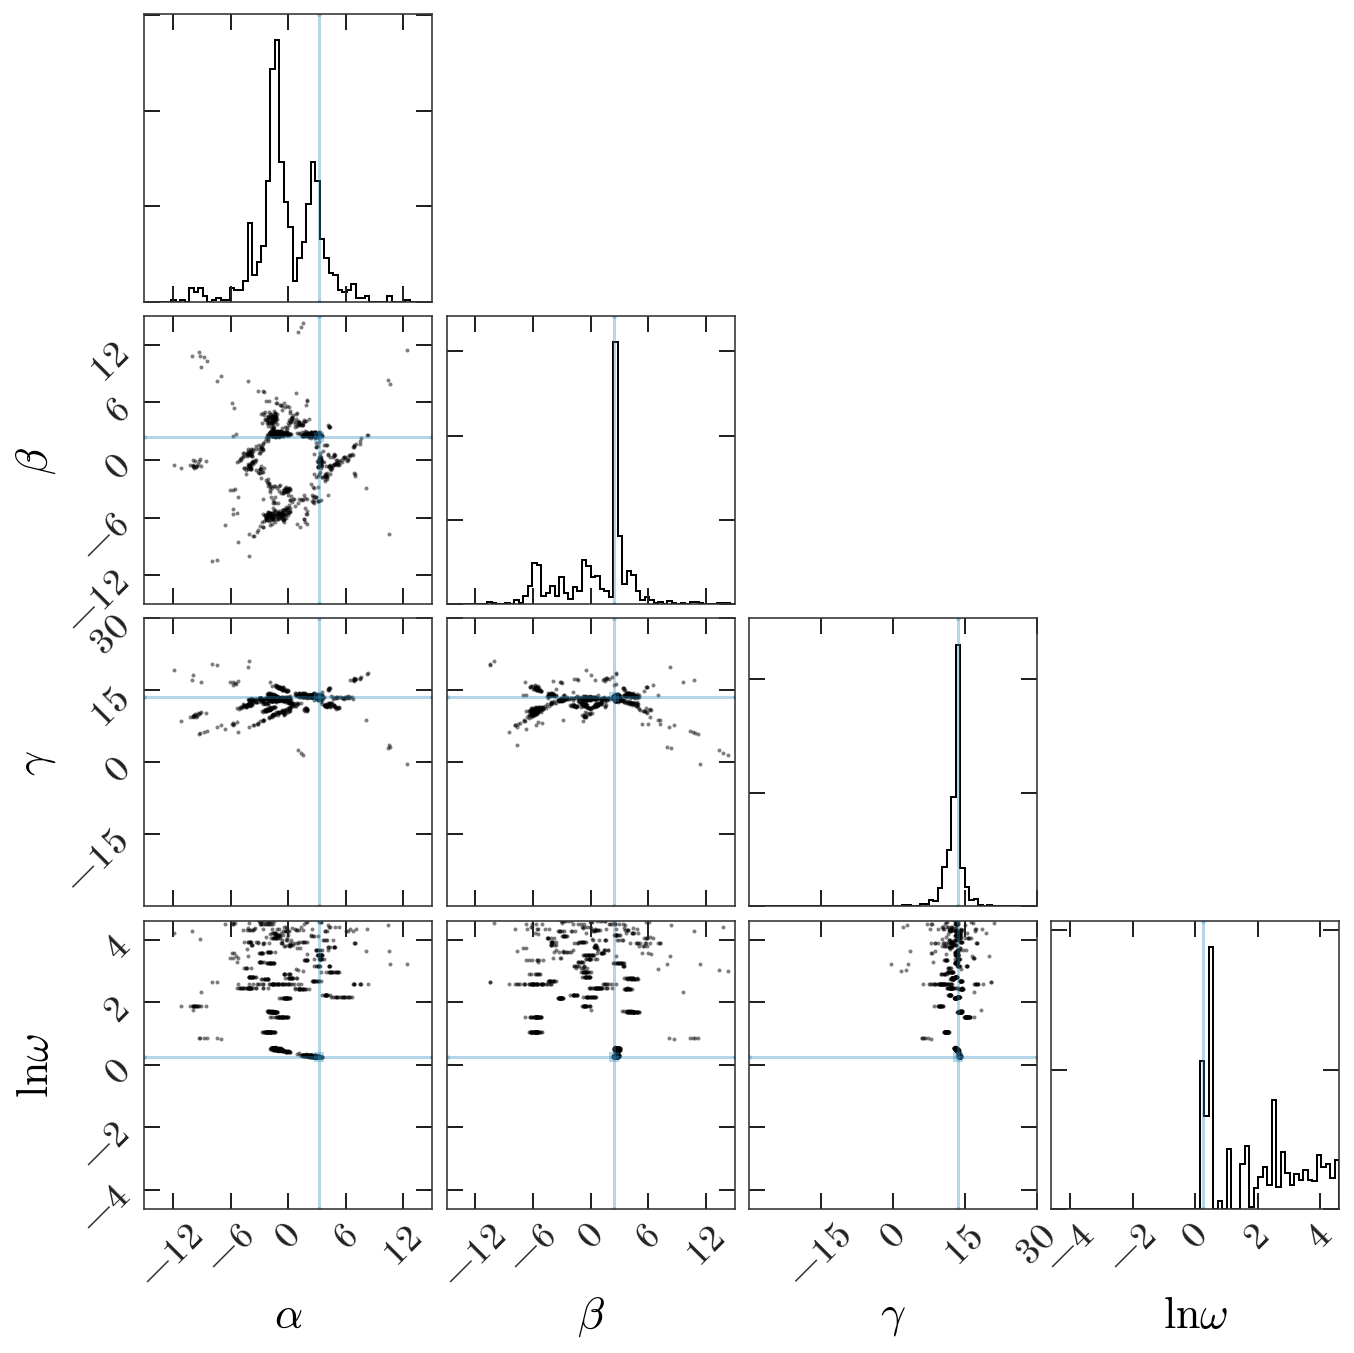

In [21]:
tmp_samples = samples.copy()
tmp_samples[:, 3] = np.log(tmp_samples[:, 3])

lims = [(mu[i] - 3*np.sqrt(L[i,i]),
         mu[i] + 3*np.sqrt(L[i,i])) for i in range(K-1)] + [np.log(omega_lim)]

tmp_pars = np.array(true_pars, copy=True)
tmp_pars[3] = np.log(tmp_pars[3])

fig = corner.corner(tmp_samples, 
                    bins=64,
                    truths=tmp_pars, 
                    range=lims,
                    plot_contours=False,
                    plot_density=False,
                    data_kwargs=dict(alpha=0.5),
                    truth_color=(0.17, 0.55, 0.75, 0.35),
                    labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\ln\omega$'])
fig.set_facecolor('w')